# 📚 Imports
---

In [367]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import collections
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from unidecode import unidecode
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

#nltk.download('stopwords')

# 📖 Data
---

In [260]:
df = pd.read_csv('data/Stress.csv')

In [261]:
df.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005


In [262]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subreddit         2838 non-null   object 
 1   post_id           2838 non-null   object 
 2   sentence_range    2838 non-null   object 
 3   text              2838 non-null   object 
 4   label             2838 non-null   int64  
 5   confidence        2838 non-null   float64
 6   social_timestamp  2838 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 155.3+ KB


In [263]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
label,2838.0,5.243129e-01,4.994965e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
confidence,2838.0,8.089718e-01,1.770383e-01,4.285714e-01,6.000000e-01,8.000000e-01,1.000000e+00,1.000000e+00
social_timestamp,2838.0,1.518107e+09,1.552209e+07,1.483274e+09,1.509698e+09,1.517066e+09,1.530898e+09,1.542592e+09


In [264]:
# Identifying null values
df.isnull().sum()

subreddit           0
post_id             0
sentence_range      0
text                0
label               0
confidence          0
social_timestamp    0
dtype: int64

# 🧺 Text Cleaning

In [266]:
# Variable to replace all characters that are not letters or whitespace
regex = re.compile('[^a-z\s]')
# Convert text to lower case
df['clean_text'] = df['text'].str.lower()
# Removes all characters that are not letters or spaces
df['clean_text'] = df['clean_text'].apply(lambda x: regex.sub('', x))
# Removes all characters between square brackets
df['clean_text'] = df['clean_text'].str.replace('[%s]', '', regex = True)
# Remove the accents
df['clean_text'] = df['clean_text'].apply(lambda x: regex.sub('', unidecode(x)))
# Remove http
df['clean_text'] = df['clean_text'].str.replace('http', '', regex = True)
# Remove words with less than 3 characters
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

In [267]:
# Tokenization
df['clean_text'] = df['clean_text'].apply(word_tokenize)

# Removing stopwords
stop_words = set(stopwords.words('english'))
df['clean_text'] = df['clean_text'].apply(lambda x: [word for word in x if word not in stop_words])

In [268]:
# Word normalization
stemmer = SnowballStemmer('english')
df['clean_text'] = df['clean_text'].apply(lambda x: [stemmer.stem(word) for word in x])

# Joining the words back into a single text
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join(x))

In [269]:
df['clean_text']

0       aid felt way ugget ret trigger ahead youir hyp...
1       hey raitanc ure thi right place pot thi goe cu...
2       mom hit newpap hock would thi know dont like p...
3       met new boyfriend amaz kind weet good tudent l...
4       octob domet violenc awaren month domet violenc...
                              ...                        
2833    week ago preciou ignor jan happi year preciou ...
2834    dont abil cope anymor tri lot thing trigger hu...
2835    cae thi time your read thi pot look peopl will...
2836    find thi normal good relationhip main problem ...
2837    talk mom thi morn aid iter trauma wore mine di...
Name: clean_text, Length: 2838, dtype: object

# 📊 Visualization
---

## Label Distribuition

Text(0.5, 1.0, 'Label Distribution')

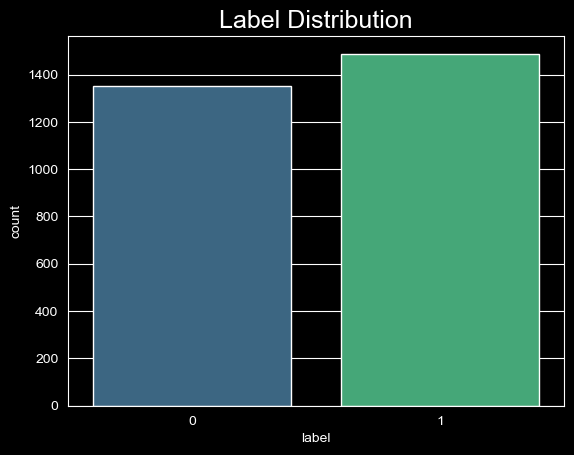

In [270]:
# Dark Background
plt.style.use('dark_background')
# Create the Countplot
sns.countplot(x = df['label'], palette = 'viridis')
# Title
plt.title('Label Distribution', fontsize = 18)

## Top 10 most used words

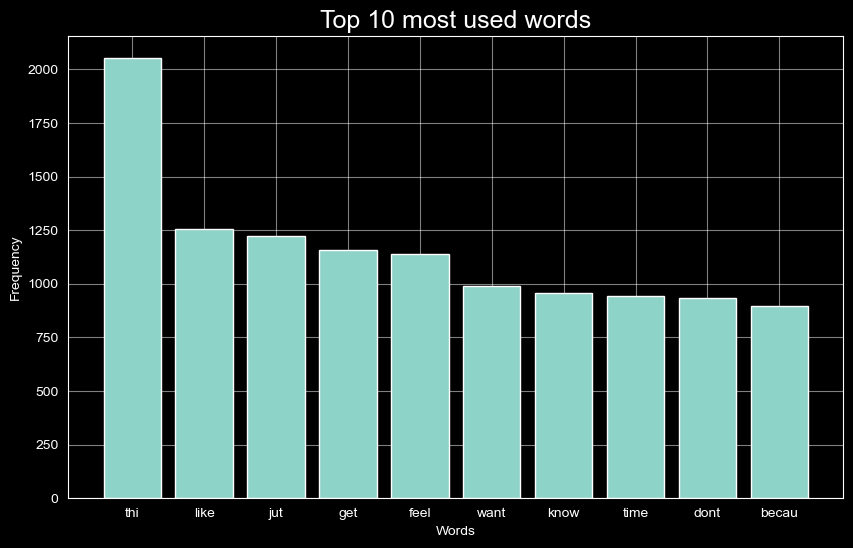

In [271]:
# Top 10 most used words
words = []
for text in df['clean_text']:
    words.extend(text.split())
word_count = collections.Counter(words)
top_words = dict(word_count.most_common(10))

# Figure Size
plt.figure(figsize = (10, 6))
# Dark Background
plt.style.use('dark_background')

# Create the Barplot
plt.bar(range(len(top_words)), list(top_words.values()), align = 'center')

# Creating a y axis with words
plt.xticks(range(len(top_words)), list(top_words.keys()))
# Grid Opacity
plt.grid(alpha = 0.5)
# Title
plt.title('Top 10 most used words', fontsize = 18)
# Labels
plt.xlabel('Words')
plt.ylabel('Frequency')
# Show
plt.show()

# WordCloud

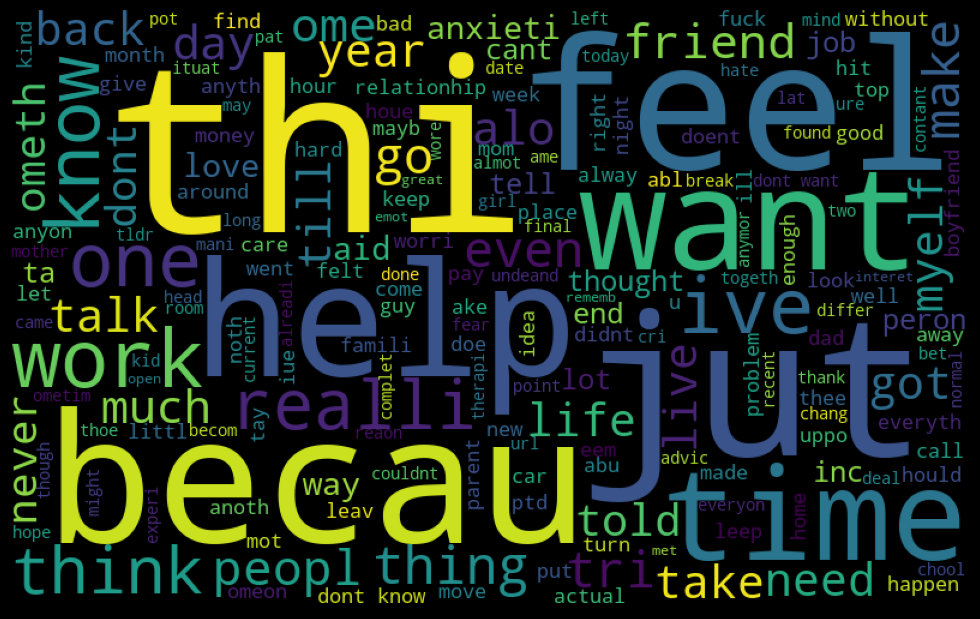

In [272]:
# Concatenating all cleaned texts into a single string
text = ' '.join(caption for caption in df['clean_text'])

# Creating a WordCloud
wordcloud = WordCloud(width = 800, height = 500, background_color = 'black', 
                min_font_size = 10).generate(text)

# Figure size and color
plt.figure(figsize = (10, 6), facecolor = None)
# Word cloud image
plt.imshow(wordcloud)
# Axis off 
plt.axis('off')
# Layout
plt.tight_layout(pad = 0)
# Show
plt.show()


# 🏋️ Training
---

In [273]:
# Renaming label column values
df['new_label'] = df['label'].map({0: 'No Stress', 1: 'Stress'})

In [357]:
# Split X and Y
x = np.array(df['clean_text'])
y = np.array(df['new_label'])

# Convert text to numerical
cv = CountVectorizer()
X = cv.fit_transform(x)

# Split Train and Test
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.20, random_state = 31)

In [358]:
# Models
mnb = MultinomialNB()
bnb = BernoulliNB()

mnb.fit(xtrain, ytrain)
bnb.fit(xtrain, ytrain)

BernoulliNB()

In [364]:
# Predictions
pred_mnb = mnb.predict(xtest)
pred_bnb = bnb.predict(xtest)

# 📋 Results
---

## MultinomialNB

In [379]:
# evaluate accuracy
print('*' * 55)
print(f'Multinomia Accuracy: {accuracy_score(ytest, pred_mnb)}')
print('*' * 55)
print(classification_report(ytest, pred_mnb))

*******************************************************
Multinomia Accuracy: 0.7852112676056338
*******************************************************
              precision    recall  f1-score   support

   No Stress       0.80      0.70      0.74       255
      Stress       0.78      0.86      0.81       313

    accuracy                           0.79       568
   macro avg       0.79      0.78      0.78       568
weighted avg       0.79      0.79      0.78       568



## BernoulliNB

In [380]:
print('*' * 55)
print(f'Bernoulli Accuracy: {accuracy_score(ytest, pred_bnb)}')
print('*' * 55)
print(classification_report(ytest, pred_bnb))

*******************************************************
Bernoulli Accuracy: 0.772887323943662
*******************************************************
              precision    recall  f1-score   support

   No Stress       0.77      0.71      0.74       255
      Stress       0.78      0.82      0.80       313

    accuracy                           0.77       568
   macro avg       0.77      0.77      0.77       568
weighted avg       0.77      0.77      0.77       568



---
# 🏁 The End! Feel free to criticize! 🏁
---